In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import pickle
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

# parameters

In [2]:
path = 'Train'
labelsfile = 'labels.csv'
batch_size_val = 50
per_epoch_steps = 502
epochs_val =10
image_dim = (32,32,3)
test_ratio = 0.2
val_ratio = 0.2

# importing all the images

In [3]:
count = 0
images= []
classNo = []
mylist = os.listdir(path)
print('TOTAL CLASS DETECTED :',len(mylist))
total_classes = len(mylist)
print('IMPORTING CLASSES..............................')
for i in range(0 , len(mylist)):
    mypiclist = os.listdir(path+'/'+str(count))
    for j in mypiclist:
        img = Image.open(path+'/'+str(count)+'/'+str(j))
        img = img.resize((32,32))
        currImg = np.array(img)
        images.append(currImg)
        classNo.append(count)
    print(count,end = ' ')
    count += 1

TOTAL CLASS DETECTED : 43
IMPORTING CLASSES..............................
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

In [4]:
print(' ')
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)
print(classNo.shape)

 
(39209, 32, 32, 3)
(39209,)


# split data

In [5]:
x_train , x_test , y_train , y_test = train_test_split(images, classNo , test_size = test_ratio)
x_train , x_val , y_train , y_val = train_test_split(x_train , y_train , test_size = val_ratio)
#x_train = array of images to train
#y_train = corresponding class ID

# to check that no. of images matches the labels for each data set

In [6]:
print('DATA SHAPE')
print('TRAIN:',end= ' ');print(x_train.shape,y_train.shape)
print('VALIDATION:',end= ' ');print(x_val.shape,y_val.shape)
print('TEST:',end= ' ');print(x_test.shape,y_test.shape)

DATA SHAPE
TRAIN: (25093, 32, 32, 3) (25093,)
VALIDATION: (6274, 32, 32, 3) (6274,)
TEST: (7842, 32, 32, 3) (7842,)


# reading the labels

In [7]:
data = pd.read_csv(labelsfile)
print(data.shape)


(43, 2)


# displaying some sample images from the data

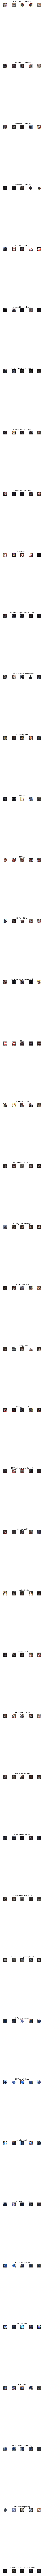

In [8]:
samples_no = []
cols =5
num_classes = total_classes
fig , axis = plt.subplots(nrows=num_classes , ncols=cols , figsize = (5,300))
fig.tight_layout()
for i in range(cols):
    for index ,rows in data.iterrows():
        x_selected = x_train[y_train==index]
        axis[index][i].imshow(x_selected[random.randint(0,len(x_selected)-1),:,:] , cmap = plt.get_cmap('gray'))
        axis[index][i].axis('off')
        if i == 2:
            axis[index][i].set_title(str(index)+'-'+rows['names'])
            samples_no.append(len(x_selected))

# displaying a bar chart


[143, 1460, 1467, 896, 1266, 1178, 270, 913, 897, 949, 1269, 848, 1357, 1418, 503, 388, 268, 696, 757, 133, 243, 205, 254, 323, 174, 935, 360, 157, 347, 176, 279, 499, 153, 428, 277, 758, 258, 119, 1331, 198, 221, 151, 171]


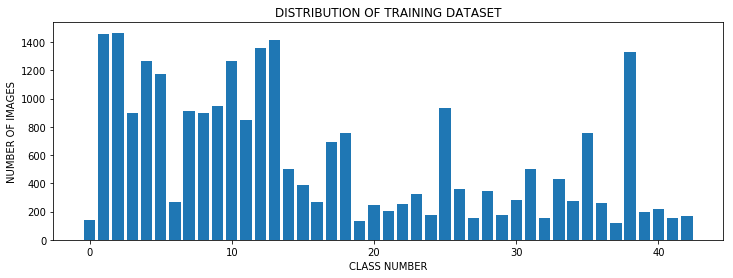

In [9]:
print(samples_no)
plt.figure(figsize=(12,4))
plt.bar(range(0 , num_classes) ,samples_no)
plt.title('DISTRIBUTION OF TRAINING DATASET')
plt.xlabel('CLASS NUMBER')
plt.ylabel('NUMBER OF IMAGES')
plt.show()

# Preprocessing the images

In [10]:
def grayscale(img):
    img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)  #converts the image into gray
    img = equalize(img)   #standardize the lighting of the image
    img = img/255         #to normalize values between 0 and 1 instead of 0 to 255
    return img
    
x_train = np.array(list(map(preprocessing ,x_train))) #to iterate through all images and preprocess the images
x_val = np.array(list(map(preprocessing ,x_val)))
x_test = np.array(list(map(preprocessing ,x_test)))

cv2.imshow('Gray Scale images', x_train[random.randint(0,len(x_train)-1)]) #to check if the training is done properly
cv2.waitKey(0)

-1

# Add a depth of 1

In [11]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

# Augmentation of images : to make them more generic

In [12]:
datagen = ImageDataGenerator(width_shift_range=0.1,  #0.1 = 10% horizontal shift
                             height_shift_range=0.1,  #vertical shift
                             zoom_range=0.2,  #0.2 means zoom range is 1 +- 0.2
                             shear_range=0.1,  #magnitude of shear angle
                             rotation_range=10 #degrees
                            )

datagen.fit(x_train)
batches = datagen.flow(x_train ,y_train , batch_size=20)  #requests datagen togenerates the images #batch size = no. of images generated each time its called
x_batch , y_batch = next(batches)

# to show augmented image samples

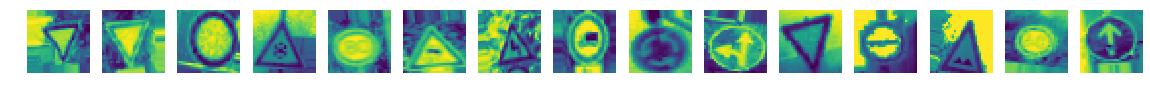

In [13]:
fig , axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout
for i in range(15):
    axs[i].imshow(x_batch[i].reshape(image_dim[0] , image_dim[1]))
    axs[i].axis('off')
plt.show()

In [14]:
y_train = to_categorical(y_train,total_classes)
y_val = to_categorical(y_val,total_classes)
y_test = to_categorical(y_test,total_classes)

# Convolutional neural network model

In [15]:
def mymodel():
    filter_no = 60
    filter1_size = (5,5) #this is the kernel that moves around the image to get the features
                        #this will remove 2 piece from the each border when using (32,32) image
    filter2_size = (3,3)
    poolsize = (2,2)   #scale down all features map generalizing more , reducws overfitting
    nodes_count = 500  #total no of nodes in hidden layer
    model = Sequential()
    model.add(Conv2D(filter_no,filter1_size , input_shape = (image_dim[0],image_dim[1],1) , activation ='relu')) #adding more convolutional layer to the model
    model.add(Conv2D(filter_no ,filter1_size,activation = 'relu'))
    model.add(MaxPool2D(pool_size = poolsize)) #does not affect the no of filters
    
    model.add(Conv2D(filter_no//2,filter2_size,activation='relu'))
    model.add(Conv2D(filter_no//2,filter2_size,activation='relu'))
    model.add(MaxPool2D(pool_size = poolsize)) 
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(nodes_count,activation='relu'))
    model.add(Dropout(0.5))  #input nodes dropped with each update 1 for all and 0 for None
    model.add(Dense(total_classes, activation ='softmax'))  #output layer
    
    #compiling the model
    model.compile(Adam(lr =0.001) , loss ='categorical_crossentropy' , metrics =['accuracy'])
    return model

# training the model

In [16]:
model =mymodel()
print(model.summary())
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size_val), 
                              steps_per_epoch = per_epoch_steps, 
                              epochs = epochs_val,
                              validation_data=(x_val, y_val),
                              shuffle = 1)

C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

C:\Users\user\Anaconda3\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
502/502 [==============================] - 265s 405ms/step - loss: 3.1177 - accuracy: 0.1535 - val_loss: 0.7663 - val_accuracy: 0.7807
Epoch 2/10
502/502 [==============================] - 181s 360ms/step - loss: 1.2749 - accuracy: 0.6037 - val_loss: 0.3181 - val_accuracy: 0.9154
Epoch 3/10
502/502 [==============================] - 181s 361ms/step - loss: 0.8408 - accuracy: 0.7372 - val_loss: 0.1939 - val_accuracy: 0.9493
Epoch 4/10
502/502 [==============================] - 182s 363ms/step - loss: 0.6395 - accuracy: 0.7971 - val_loss: 0.1435 - val_accuracy: 0.9571
Epoch 5/10
502/502 [==============================] - 182s 363ms/step - loss: 0.5342 - accuracy: 0.8290 - val_loss: 0.1362 - val_accuracy: 0.9640
Epoch 6/10
502/502 [==============================] - 182s 362ms/step - loss: 0.4562 - accuracy: 0.8594 - val_loss: 0.0845 - val_accuracy: 0.9794
Epoch 7/10
502/502 [==============================] - 182s 363ms/step - loss: 0.4009 - accuracy: 0.8737 - val_loss: 0.0831 -

# plot

Text(0.5, 0, 'epoch')

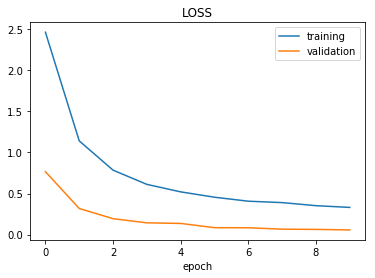

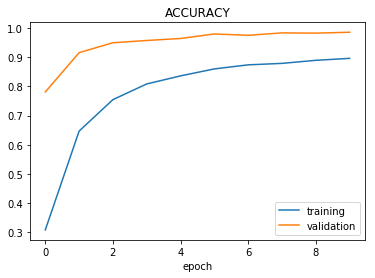

In [17]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training' ,'validation'])
plt.title('LOSS')
plt.xlabel('epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training' ,'validation'])
plt.title('ACCURACY')
plt.xlabel('epoch')

# storing the object as a joblib object

In [18]:
model.save('model_trained.h5')